### Instalación de librerías necesarias
Si no tienes instaladas las librerías requeridas para este notebook, ejecuta la siguiente celda:


In [1]:
%pip install matplotlib seaborn scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


O bien:

In [2]:
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn scikit-learn

## 1. Comparación visual de escaladores con PCA

En esta primera parte, queremos observar cómo afectan tres métodos de escalado diferentes (`StandardScaler`, `MinMaxScaler` y `RobustScaler`) a la forma en la que se distribuyen los datos cuando los reducimos a 2 dimensiones usando PCA.

Aunque el objetivo final es hacer clustering, primero necesitamos transformar los datos para que las variables estén en una escala comparable. Esto nos ayuda a evitar que algunas características dominen a otras simplemente por tener valores más grandes.

Vamos a usar una `pipeline` que aplica el escalado y luego el PCA. Finalmente, representamos los datos en un gráfico para comparar los resultados.


In [3]:
# importamos librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns

In [4]:
# Cargar el dataset de semillas
df = pd.read_csv('../semillas.csv')

# Separar atributos (X) y clase (y)
X = df.drop(columns=['clase']).values
y = df['clase'].values  # Solo para colorear el gráfico (NO usar en clustering)

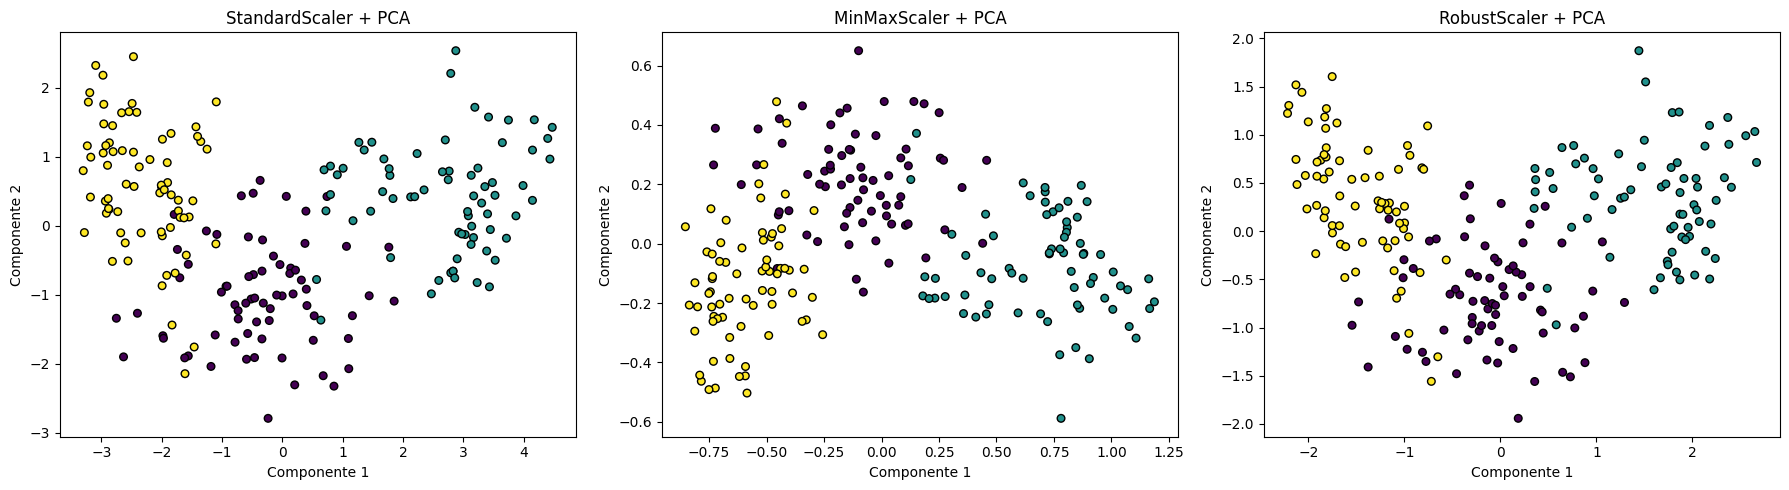

In [5]:
# Diccionario que contiene los diferentes tipos de escaladores que vamos a utilizar
# StandardScaler: Estandariza las características restando la media y escalando a varianza unitaria
# MinMaxScaler: Escala las características al rango [0,1]
# RobustScaler: Escala usando estadísticas robustas a valores atípicos
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Crear una figura con un tamaño específico para mostrar los tres gráficos
plt.figure(figsize=(18, 5))

# Iterar sobre cada escalador para crear un gráfico para cada uno
for i, (name, scaler) in enumerate(scalers.items()):
    # Crear un pipeline que combina el escalado de datos y la reducción de dimensionalidad
    # El pipeline primero escala los datos y luego aplica PCA para reducir a 2 dimensiones
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2))
    ])
    
    # Aplicar la transformación completa a los datos
    # Esto escala los datos y luego aplica PCA para obtener las dos componentes principales
    X_pca = pipeline.fit_transform(X)
    
    # Crear un subgráfico para cada escalador
    plt.subplot(1, 3, i+1)
    # Crear un gráfico de dispersión donde:
    # - X_pca[:, 0] son los valores de la primera componente principal
    # - X_pca[:, 1] son los valores de la segunda componente principal
    # - c=y colorea los puntos según la variable objetivo
    # - cmap='viridis' define la paleta de colores
    # - edgecolor='k' establece el borde de los puntos en negro
    # - s=30 define el tamaño de los puntos
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=30)
    plt.title(f'{name} + PCA')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')

# Ajustar el diseño para evitar superposición de subgráficosy mostrar la figura completa
plt.tight_layout()
plt.show()

### Comparación visual de escaladores

En estos gráficos vemos cómo cambia la forma en que se reparten los datos cuando usamos diferentes formas de escalarlos antes de aplicar PCA. Aunque los colores indican la clase original de cada semilla, no se han usado para entrenar nada. Solo los mostramos para tener una referencia visual.

Lo que buscamos aquí es ver si los datos se separan de forma más clara con algún escalador en particular. En mi caso, el que parece funcionar mejor es StandardScaler, ya que los grupos se distinguen mejor visualmente, sin tanto solapamiento entre ellos.

- **StandardScaler + PCA:**  
  Esta transformación parece ser la que mejor separa visualmente los grupos. Los puntos se distribuyen bastante bien a lo largo de los dos componentes principales, y se distinguen tres zonas bastante definidas, lo que puede facilitar la tarea de clustering. Además, los datos se ven más centrados y simétricos, sin demasiada compresión ni distorsión.

- **MinMaxScaler + PCA:**  
  En este caso, los puntos están más apretados y la escala de los ejes es muy pequeña (entre -1 y 1). Aunque se siguen viendo agrupaciones, los grupos están más solapados. Esto podría dificultar que los algoritmos de clustering detecten bien las fronteras. Es un escalado útil en algunos casos, pero aquí parece menos efectivo.

- **RobustScaler + PCA:**  
  Esta opción también ofrece una separación razonable. Funciona especialmente bien cuando hay valores extremos (outliers), ya que usa la mediana y los cuartiles para escalar. En este ejemplo concreto, los datos se ven más dispersos que con MinMax, y las agrupaciones son más claras, aunque algo menos que con StandardScaler.

Esta observación es importante porque nos puede ayudar a elegir el mejor preprocesamiento antes de pasar a hacer clustering en la siguiente parte.

Ahora vamos a elegir uno de esos escaladores, en este caso StandardScaler, (porque se ve que separa mejor los grupos) y aplicar los algoritmos de clustering sobre esa versión de los datos.

Empezamos por el primero: K-Means.

PASO 1: Aplicar StandardScaler + PCA y guardar los datos para clustering


In [6]:
# Usamos StandardScaler, que fue el más claro visualmente
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

pca_final = PCA(n_components=2)
X_pca_std = pca_final.fit_transform(X_scaled)

PASO 2: Elegir cuántos clusters usar con el método del codo

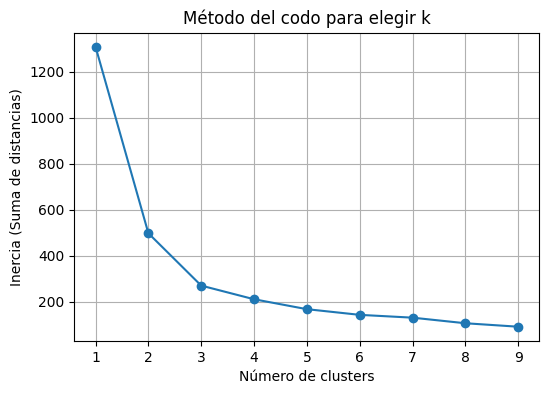

In [7]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Método del codo para elegir k')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de distancias)')
plt.grid(True)
plt.show()

 (Cuando la curva deja de bajar fuerte, ese es un buen valor de k)
  
  La mayor bajada de inercia ocurre entre k = 1 y k = 3. Después de k = 3, las mejoras son cada vez más pequeñas. Eso significa que k = 3 es un buen punto de corte: justo ahí el "codo" de la curva se estabiliza.

PASO 3: Aplicar K-Means con k=3 y ver cómo se agrupan los puntos.

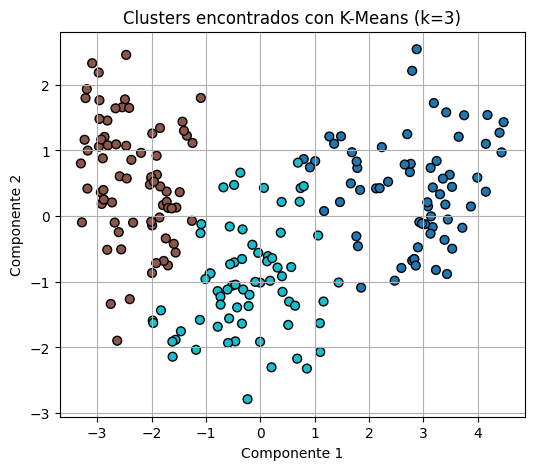

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar KMeans con k = 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca_std)

# Visualización
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_kmeans, cmap='tab10', s=40, edgecolor='k')
plt.title(f'Clusters encontrados con K-Means (k={k})')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

### Clustering con K-Means

Según el gráfico del método del codo, el valor más adecuado para `k` es 3. A partir de ese punto, la inercia (o suma de distancias internas a los clusters) ya no disminuye de forma significativa.

Con este valor, K-Means ha agrupado los datos en tres grupos diferentes. Aunque no hemos usado la clase real, visualmente se observa que las agrupaciones parecen tener cierta coherencia. Más adelante compararemos estas agrupaciones con las clases originales para ver si coinciden.


Aplicamos K-Means a los datos procesados con StandardScaler y PCA. Usamos el método del codo para determinar el valor más adecuado de `k`, y seleccionamos `k=3` porque la inercia deja de reducirse significativamente a partir de ahí.

El gráfico muestra cómo el algoritmo ha separado los puntos en tres grupos distintos. Esta agrupación no utiliza la clase real, y servirá como comparación con los otros métodos de clustering que aplicaremos después.